In [1]:
import numpy as np

In [23]:
X_train_fpath = 'X_train'
Y_train_fpath = 'Y_train'
X_test_fpath = 'X_test'
output_fpath = 'output.csv'

In [24]:
X_train = np.genfromtxt(X_train_fpath, delimiter=',', skip_header=1)
Y_train = np.genfromtxt(Y_train_fpath, delimiter=',', skip_header=1)

In [35]:
def _normalize_column_0_1(X, train=True, specified_column = None, X_min = None, X_max=None):
    # The output of the function will make the specified column of the training data 
    # from 0 to 1
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the max value of the 
    # training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        X_max = np.reshape(np.max(X[:, specified_column], 0), (1, length))
        X_min = np.reshape(np.min(X[:, specified_column], 0), (1, length))
        
    X[:, specified_column] = np.divide(np.subtract(X[:, specified_column], X_min), np.subtract(X_max, X_min))

    return X, X_max, X_min

In [36]:
def _normalize_column_normal(X, train=True, specified_column = None, X_mean=None, X_std=None):
    # The output of the function will make the specified column number to 
    # become a Normal distribution
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the mean value and 
    # the variance of the training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        X_mean = np.reshape(np.mean(X[:, specified_column],0), (1, length))
        X_std  = np.reshape(np.std(X[:, specified_column], 0), (1, length))
    
    X[:,specified_column] = np.divide(np.subtract(X[:,specified_column],X_mean), X_std)
     
    return X, X_mean, X_std

In [37]:
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])
    
def train_dev_split(X, y, dev_size=0.25):
    train_len = int(round(len(X)*(1-dev_size)))
    return X[0:train_len], y[0:train_len], X[train_len:None], y[train_len:None]

In [44]:
 
# These are the columns that I want to normalize
col = [0,1,3,4,5,7,10,12,25,26,27,28]
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)

In [45]:
# validation and shuffle(for batch)
def _shuffle(X, y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], y[randomize]
def set_validation(X, y, ratio=0.25):
    trainlen = int(round(len(X) * (1 - ratio)))
    return X[0:trainlen], y[0:trainlen], X[trainlen:None], y[trainlen:None]


In [103]:
# logistic regression
def sigmoid(z):
    return np.clip(1 / (1 + np.exp(-z)), 1e-6, 1 - 1e-6)
# def estimate_prob(x, w, b):
#     return sigmoid(np.add(np.matmul(x, w), b))

def estimate_prob(x, w, b):
    return (sigmoid(np.dot(x, w) + b))

# def cross_validation(y_pred, y_true):
#     cross_entropy = - y_true.dot(np.log(y_pred)) - (1 - y_true).dot(np.log(1 - y_pred))
#     return cross_entropy
def cross_validation(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy
def gradient(x, y_true, w, b):
    y_pred = estimate_prob(x, w, b)
    m = len(y_true)
    w_grad = -1 / m * ((x.T).dot(y_pred - y_true))
    b_grad = - 1 / m * np.sum((y_pred - y_true))
    return w_grad, b_grad
def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = estimate_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1) + lamda * w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad
def regulization_gradient(x, y_true, w, b, lamba):
    y_pred = estimate_prob(x, w, b)
    m = len(y_true)
    w_grad = (-1 / m) * ((x.T).dot((y_true - y_pred))) + lamba * w
    b_grad = (- 1 / m) * np.sum(y_true - y_pred)
    return w_grad, b_grad
def regulization_loss(y_pred, y_true, lamba, w):
    return cross_validation(y_pred, y_true) + lamba * np.sum(np.square(w))
def accuracy(y_pred, y_true):
    acc = np.sum(y_pred == y_true) / len(y_pred)
    return acc


In [104]:
# run gradient
def run_gradient(x_train, y_train , learning_rate=0.01):
    validation_ratio=0.1225
    x_train, y_train, x_val, y_val = set_validation(X_train, Y_train, ratio=validation_ratio)
    w = np.zeros((x_train.shape[1],))
    b = np.zeros((1,))
    # r_w = np.zeros((x_train.shape[1],))
    # r_b = np.zeros((1,))
    regulization = True
    if regulization is True:
        lamba = 0.001
    else:
        lamba = 0

    iteration = 40
    batch_size = 32
    # learning_rate = 0.001
    # decay_rate = 0.99
    step = 1  # for decay
    loss_train = []
    loss_val = []
    train_acc = []
    val_acc = []
    # run
    for epoch in range(iteration):
        x_train, y_train = _shuffle(x_train, y_train)
        for id in range(int(np.floor(len(y_train) / batch_size))):
            X = x_train[id * batch_size:(id + 1) * batch_size]
            Y = y_train[id * batch_size:(id + 1) * batch_size]

            w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamba)
            w = w - learning_rate / np.sqrt(step) * w_grad
            b = b - learning_rate / np.sqrt(step) * b_grad

            step = step + 1
            # r_w = r_w * decay_rate + ((1 - decay_rate) * np.multiply(w_grad, w_grad))
            # r_b = r_b * decay_rate + ((1 - decay_rate) * np.multiply(b_grad, b_grad))
            # w = w - ((learning_rate / (np.sqrt(r_w) + 0.0000001)) * w_grad)
            # b = b - ((learning_rate / (np.sqrt(r_b) + 0.0000001)) * b_grad)

        # loss and acc for each iteration
        y_train_pred = estimate_prob(x_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, y_train))
        loss_train.append(regulization_loss(y_train_pred, y_train, lamba, w) / len(y_train))

        y_val_pred = estimate_prob(x_val, w, b)
        Y_val_pred = np.round(y_val_pred)
        val_acc.append(accuracy(Y_val_pred, y_val))
        loss_val.append(regulization_loss(y_val_pred, y_val, lamba, w) / len(y_val))
    return w, b, train_acc, loss_train, val_acc, loss_val


w, b, train_acc, loss_train, val_acc, loss_val = run_gradient(X_train, Y_train, learning_rate=0.2)


In [99]:
validation_ratio=0.1225
learning_rate = 0.15
x_train, y_train, x_val, y_val = set_validation(X_train, Y_train, ratio=validation_ratio)
w = np.zeros((x_train.shape[1],))
b = np.zeros((1,))
# r_w = np.zeros((x_train.shape[1],))
# r_b = np.zeros((1,))
regulization = True
if regulization is True:
    lamba = 0.001
else:
    lamba = 0

iteration = 40
batch_size = 32
# learning_rate = 0.001
# decay_rate = 0.99
step = 1  # for decay
loss_train = []
loss_val = []
train_acc = []
val_acc = []
# run
for epoch in range(iteration):
    x_train, y_train = _shuffle(x_train, y_train)
    for id in range(int(np.floor(len(y_train) / batch_size))):
        X = x_train[id * batch_size:(id + 1) * batch_size]
        Y = y_train[id * batch_size:(id + 1) * batch_size]

        w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamba)
        w = w - learning_rate / np.sqrt(step) * w_grad
        b = b - learning_rate / np.sqrt(step) * b_grad

        step = step + 1
# loss and acc for each iteration
    y_train_pred = estimate_prob(x_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(accuracy(Y_train_pred, y_train))
    loss_train.append(regulization_loss(y_train_pred, y_train, lamba, w) / len(y_train))

    y_val_pred = estimate_prob(x_val, w, b)
    Y_val_pred = np.round(y_val_pred)
    val_acc.append(accuracy(Y_val_pred, y_val))
    loss_val.append(regulization_loss(y_val_pred, y_val, lamba, w) / len(y_val))

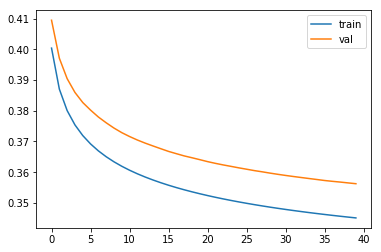

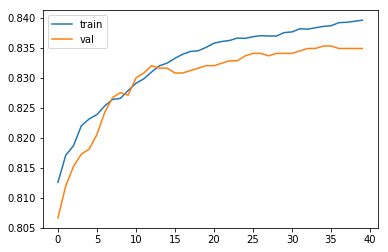

In [105]:
# plot
plt.plot(loss_train)
plt.plot(loss_val)
plt.legend(['train', 'val'])
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])

plt.show()

In [49]:
def _sigmoid(z):
    # sigmoid function can be used to output probability
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1-1e-6)

def get_prob(X, w, b):
    # the probability to output 1
    return _sigmoid(np.add(np.matmul(X, w), b))

def infer(X, w, b):
    # use round to infer the result
    return np.round(get_prob(X, w, b))

def _cross_entropy(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)+lamda*w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _loss(y_pred, Y_label, lamda, w):
    return _cross_entropy(y_pred, Y_label) + lamda * np.sum(np.square(w))

def accuracy(Y_pred, Y_label):
    acc = np.sum(Y_pred == Y_label)/len(Y_pred)
    return acc

In [71]:
def train(X_train, Y_train):
    # split a validation set
    dev_size = 0.1155
    X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = dev_size)
    
    # Use 0 + 0*x1 + 0*x2 + ... for weight initialization
    w = np.zeros((X_train.shape[1],)) 
    b = np.zeros((1,))

    regularize = True
    if regularize:
        lamda = 0.001
    else:
        lamda = 0
    
    max_iter = 40  # max iteration number
    batch_size = 32 # number to feed in the model for average to avoid bias
    learning_rate = 0.2  # how much the model learn for each step
    num_train = len(Y_train)
    num_dev = len(Y_dev)
    step =1

    loss_train = []
    loss_validation = []
    train_acc = []
    dev_acc = []
    
    for epoch in range(max_iter):
        # Random shuffle for each epoch
        X_train, Y_train = _shuffle(X_train, Y_train)
        
        total_loss = 0.0
        # Logistic regression train with batch
        for idx in range(int(np.floor(len(Y_train)/batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]
            
            # Find out the gradient of the loss
            w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamda)
            
            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad
            
            step = step+1
            
        # Compute the loss and the accuracy of the training set and the validation set
        y_train_pred = get_prob(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, Y_train))
        loss_train.append(_loss(y_train_pred, Y_train, lamda, w)/num_train)
        
        y_dev_pred = get_prob(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        dev_acc.append(accuracy(Y_dev_pred, Y_dev))
        loss_validation.append(_loss(y_dev_pred, Y_dev, lamda, w)/num_dev)
    
    return w, b, loss_train, loss_validation, train_acc, dev_acc  # return loss for plotting

In [69]:
_loss(Y_train_pred,Y_train, lamda, w)

/Users/ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


nan

In [80]:
# split a validation set
dev_size = 0.1155
X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = dev_size)

# Use 0 + 0*x1 + 0*x2 + ... for weight initialization
w = np.zeros((X_train.shape[1],)) 
b = np.zeros((1,))

regularize = True
if regularize:
    lamda = 0.001
else:
    lamda = 0

max_iter = 40  # max iteration number
batch_size = 32 # number to feed in the model for average to avoid bias
learning_rate = 0.2  # how much the model learn for each step
num_train = len(Y_train)
num_dev = len(Y_dev)
step =1

loss_train = []
loss_validation = []
train_acc = []
dev_acc = []

for epoch in range(max_iter):
    # Random shuffle for each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)

    total_loss = 0.0
    # Logistic regression train with batch
    for idx in range(int(np.floor(len(Y_train)/batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Find out the gradient of the loss
        w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamda)

        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step+1

    # Compute the loss and the accuracy of the training set and the validation set
    y_train_pred = get_prob(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(accuracy(Y_train_pred, Y_train))
    loss_train.append(_loss(y_train_pred, Y_train, lamda, w)/num_train)

    y_dev_pred = get_prob(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(accuracy(Y_dev_pred, Y_dev))
    loss_validation.append(_loss(y_dev_pred, Y_dev, lamda, w)/num_dev)

In [82]:
_loss(y_train_pred, Y_train, lamda, w)/num_train

0.34508480790624024

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
# return loss is to plot the result
w, b, loss_train, loss_validation, train_acc, dev_acc= train(X_train, Y_train)

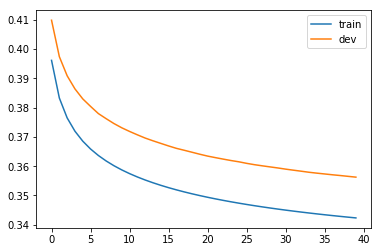

In [76]:
plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'dev'])
plt.show()

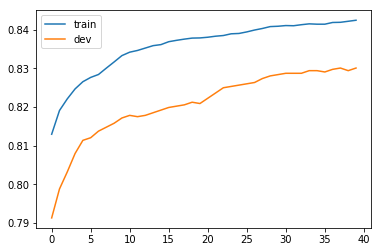

In [74]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.show()
